## Mini Project

#### Goal

The objective of this project was to forecast the total number of global air passengers per month using historical data. The idea was to capture seasonality and holiday effects that drive spikes in travel, while also accounting for abnormal events that disrupt typical patterns.

By forecasting passenger demand, airlines, airports, and policymakers could:

- Anticipate peak months (e.g., July, December).
- Adjust staffing, pricing, and promotions accordingly.
- Understand the long-term impact of disruptions (e.g., COVID-19).

Dataset is from Kaggle: https://www.kaggle.com/datasets/umerhaddii/global-holidays-and-travel-data/data 

In [1]:
import pandas as pd
import numpy as np

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt

In [2]:
#Load the dataset
travel = pd.read_csv('data/monthly_passengers.csv')
global_holidays = pd.read_csv('data/global_holidays.csv')

In [3]:
travel.head()

,ISO3,Year,Month,Total,Domestic,International,Total_OS
0,ALB,2010,1,NaN,NaN,NaN,117.350
1,ALB,2010,2,NaN,NaN,NaN,86.535
2,ALB,2010,3,NaN,NaN,NaN,103.795
3,ALB,2010,4,NaN,NaN,NaN,102.038
4,ALB,2010,5,NaN,NaN,NaN,109.037


In [4]:
global_holidays.head()

,ADM_name,ISO3,Date,Name,Type
0,Aruba,ABW,2010-01-01,New Year's Day,Public holiday
1,Aruba,ABW,2010-01-25,Betico Croes' Birthday,Public holiday
2,Aruba,ABW,2010-02-15,Carnival Monday,Public holiday
3,Aruba,ABW,2010-03-18,National Anthem and Flag Day,Public holiday
4,Aruba,ABW,2010-04-02,Good Friday,Public holiday


In [5]:
global_holidays.shape, travel.shape

((44393, 5), (7242, 7))

In [6]:
travel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7242 entries, 0 to 7241
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ISO3           7242 non-null   object 
 1   Year           7242 non-null   int64  
 2   Month          7242 non-null   int64  
 3   Total          3955 non-null   float64
 4   Domestic       3292 non-null   float64
 5   International  3847 non-null   float64
 6   Total_OS       6594 non-null   float64
dtypes: float64(4), int64(2), object(1)
memory usage: 396.2+ KB


In [7]:
global_holidays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44393 entries, 0 to 44392
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ADM_name  44393 non-null  object
 1   ISO3      44393 non-null  object
 2   Date      44393 non-null  object
 3   Name      44393 non-null  object
 4   Type      44393 non-null  object
dtypes: object(5)
memory usage: 1.7+ MB


In [8]:
#Align the datasets

global_holidays['Date'] = pd.to_datetime(global_holidays['Date'])
global_holidays['month'] = global_holidays['Date'].dt.to_period('M')

holiday_counts = global_holidays.groupby('month').size().reset_index(name = 'holiday_count')
holiday_counts['date'] = holiday_counts['month'].dt.to_timestamp()

In [9]:
holiday_counts.head()

,month,holiday_count,date
0,2010-01,317,2010-01-01
1,2010-02,311,2010-02-01
2,2010-03,205,2010-03-01
3,2010-04,596,2010-04-01
4,2010-05,605,2010-05-01


#### Aggregate Globally

- collapse across all ISO3 values to get one series of monthly totals.

In [10]:
global_monthly = (
    travel.groupby(['Year', 'Month'], as_index = False)['Total'].sum()
                 )

In [11]:
global_monthly['date'] = pd.to_datetime(
    global_monthly['Year'].astype(str) + '-' + global_monthly['Month'].astype(str) + '-01'
)

global_monthly = global_monthly[['date', 'Total']].sort_values('date')

In [12]:
#Merge with global passengers
global_monthly = global_monthly.merge(holiday_counts[['date', 'holiday_count']], on = 'date', how = 'left')

In [13]:
#Fill null values - no null values (even though no null values)
global_monthly['holiday_count'] = global_monthly['holiday_count'].fillna(0)
global_monthly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           120 non-null    datetime64[ns]
 1   Total          120 non-null    float64       
 2   holiday_count  120 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 2.9 KB


#### Train Forecasting Model

In [14]:
#Feature engineering
global_monthly['month'] = global_monthly['date'].dt.month
global_monthly['year'] = global_monthly['date'].dt.year
global_monthly['lag_1'] = global_monthly['Total'].shift(1)
global_monthly['lag_12'] = global_monthly['Total'].shift(12)

In [15]:
global_monthly.head()

,date,Total,holiday_count,month,year,lag_1,lag_12
0,2010-01-01,157748.353,317,1,2010,NaN,NaN
1,2010-02-01,152733.118,311,2,2010,157748.353,NaN
2,2010-03-01,185028.498,205,3,2010,152733.118,NaN
3,2010-04-01,172140.208,596,4,2010,185028.498,NaN
4,2010-05-01,196935.072,605,5,2010,172140.208,NaN


In [16]:
#Drop NA from lagging
ml_data = global_monthly.dropna()

In [17]:
X = ml_data[['month', 'year', 'holiday_count', 'lag_1', 'lag_12']]
y = ml_data['Total']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = False, test_size = 12)

model = xgb.XGBRegressor(n_estimators = 300, max_depth = 5)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [18]:
print('Global RMSE:', rmse)

Global RMSE: 280075.6212601261


In [24]:
test = ml_data[-12:]

In [25]:
test

,date,Total,holiday_count,month,year,lag_1,lag_12
108,2019-01-01,53409.0,326,1,2019,268214.126,242791.960
109,2019-02-01,53827.0,224,2,2019,53409.000,237366.134
110,2019-03-01,53504.0,262,3,2019,53827.000,279392.653
111,2019-04-01,53118.0,655,4,2019,53504.000,289669.417
112,2019-05-01,54509.0,557,5,2019,53118.000,305248.930
113,2019-06-01,53414.0,478,6,2019,54509.000,320991.283
114,2019-07-01,59304.0,182,7,2019,53414.000,348848.737
115,2019-08-01,0.0,383,8,2019,59304.000,348114.244
116,2019-09-01,0.0,223,9,2019,0.000,311907.206
117,2019-10-01,0.0,271,10,2019,0.000,310498.888


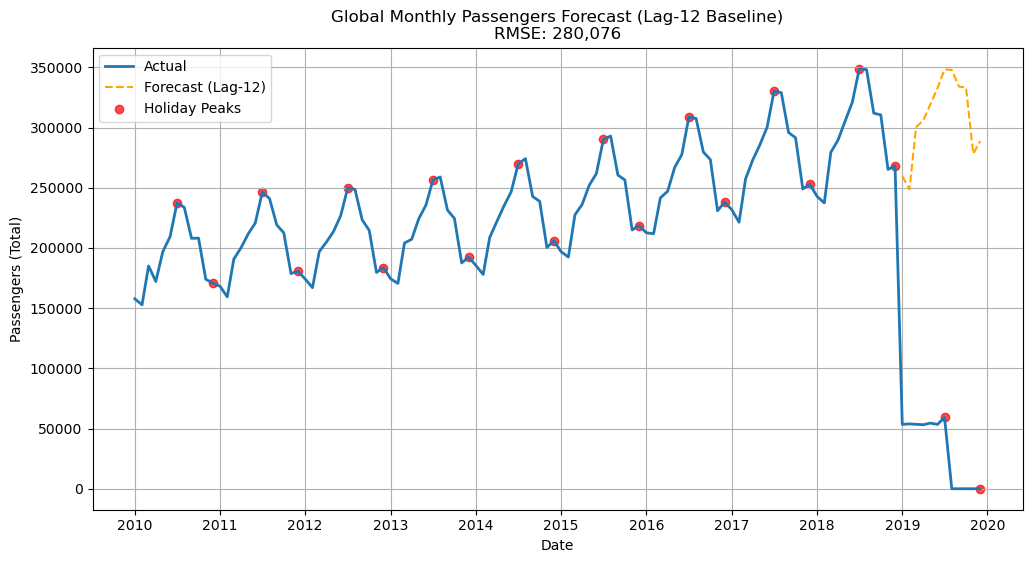

In [21]:
plt.figure(figsize = (12, 6))
plt.plot(global_monthly['date'], global_monthly['Total'], label = 'Actual', linewidth = 2)
plt.plot(test['date'], y_pred, label="Forecast (Lag-12)", linestyle="--", color="orange")

# Highlight holiday months (July & December)
holiday_months = global_monthly[global_monthly['date'].dt.month.isin([7,12])]
plt.scatter(holiday_months['date'], holiday_months['Total'],
            color='red', label="Holiday Peaks", alpha=0.7)

plt.title(f"Global Monthly Passengers Forecast (Lag-12 Baseline)\nRMSE: {rmse:,.0f}")
plt.xlabel("Date")
plt.ylabel("Passengers (Total)")
plt.legend()
plt.grid(True)
plt.show()

#### Explaination
- I can clearly see the yearly seasonality with peaks (likely holiday months) and troughs.

- Around 2019–2020, the line collapses sharply toward zero — probably missing/abnormal data or a real-world disruption (COVID-19)